Import Libraries

In [1]:
from itertools import compress
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
from scipy import interpolate
import math
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, GridSearchCV
# from pyriemann.estimation import XdawnCovariances
# from pyriemann.classification import MDM
import pyriemann
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

from mne.decoding import UnsupervisedSpatialFilter, SlidingEstimator
from mne.preprocessing.nirs import optical_density, beer_lambert_law, scalp_coupling_index, temporal_derivative_distribution_repair
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.channels import picks_pair_to_idx as p2idx
from mne_nirs.signal_enhancement import (enhance_negative_correlation,
                                         short_channel_regression)
from mne.viz import plot_compare_evokeds
from mne_nirs.experimental_design import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

import mne
from mne.decoding import Scaler, cross_val_multiscore, Vectorizer
from mne import Epochs, events_from_annotations, set_log_level
from mne.io import read_raw_snirf
from mne_nirs.io.snirf import write_raw_snirf
from mne_bids import write_raw_bids, BIDSPath, read_raw_bids

Define Preprocessing and Learning Function

In [14]:
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_snirf(bids_path, verbose=False)

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    # raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(1.0)
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od = short_channel_regression(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od)
    
    ## FILTERS OUT HEART RATE
    raw_haemo = raw_haemo.filter(None, 0.4,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)
    raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    # Pick data channels that are actually informative
    roi_channels = mne.pick_channels(raw_haemo.info['ch_names'], include=['Left_PT','Right_PT'])
    raw_haemo = raw_haemo.copy().pick_channels(roi_channels)

    # Extract events but ignore those with
    events, event_dict = events_from_annotations(raw_haemo, verbose=False,
                                                 regexp='^(?![Ends]).*$')
    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-5, tmax=30,
                    reject=dict(hbo=100e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=1,
                    preload=True, verbose=False,event_repeated='merge')

    return raw_haemo, epochs

In [12]:
def learn(ch_type):
    aux_clf = make_pipeline(
        Scaler(aux_epochs.info), 
        Vectorizer(), LogisticRegression(solver="liblinear")
    )

    aux_st_scores = cross_val_multiscore(
        aux_clf,
        aux_x_all,
        aux_y_all,
        cv=cv,
        groups=aux_groups,
        n_jobs=1,
        scoring="roc_auc",
    )

    aux_scores.append(
        pd.DataFrame({"Score": aux_st_scores, "method":"Basic","Channel Type": ch_type})
    )

Determining Important ROIs

Reading 0 ... 7976  =      0.000 ...  2041.856 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 92.6 mm
Reading 0 ... 7540  =      0.000 ...  1930.240 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 92.6 mm
Reading 0 ... 7478  =      0.000 ...  1914.368 secs...


C:\Users\dalto\AppData\Local\Temp\ipykernel_5112\3120884653.py:9: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


Reading 0 ... 7340  =      0.000 ...  1879.040 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 92.6 mm
Reading 0 ... 7705  =      0.000 ...  1972.480 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 92.6 mm


C:\Users\dalto\AppData\Local\Temp\ipykernel_5112\3901097506.py:15: RuntimeWarning: No matching channels found for source 5 detector 4
  Left_HG=p2idx(raw_haemo, [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]], on_missing='warning'),
C:\Users\dalto\AppData\Local\Temp\ipykernel_5112\3901097506.py:15: RuntimeWarning: No matching channels found for source 5 detector 5
  Left_HG=p2idx(raw_haemo, [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]], on_missing='warning'),
C:\Users\dalto\AppData\Local\Temp\ipykernel_5112\3901097506.py:15: RuntimeWarning: No matching channels found for source 6 detector 5
  Left_HG=p2idx(raw_haemo, [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]], on_missing='warning'),
C:\Users\dalto\AppData\Local\Temp\ipykernel_5112\3901097506.py:16: RuntimeWarning: No matching channels found for source 6 detector 6
  Left_PT=p2idx(raw_haemo, [[6,6], [6,7], [7,5], [7,7], [8,6], [8,7]], on_missing='warning'),
C:\Users\dalto\AppData\Local\Temp\ipykernel_5112\3901097506.py:16: RuntimeWarning: No ma

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


KeyboardInterrupt: 

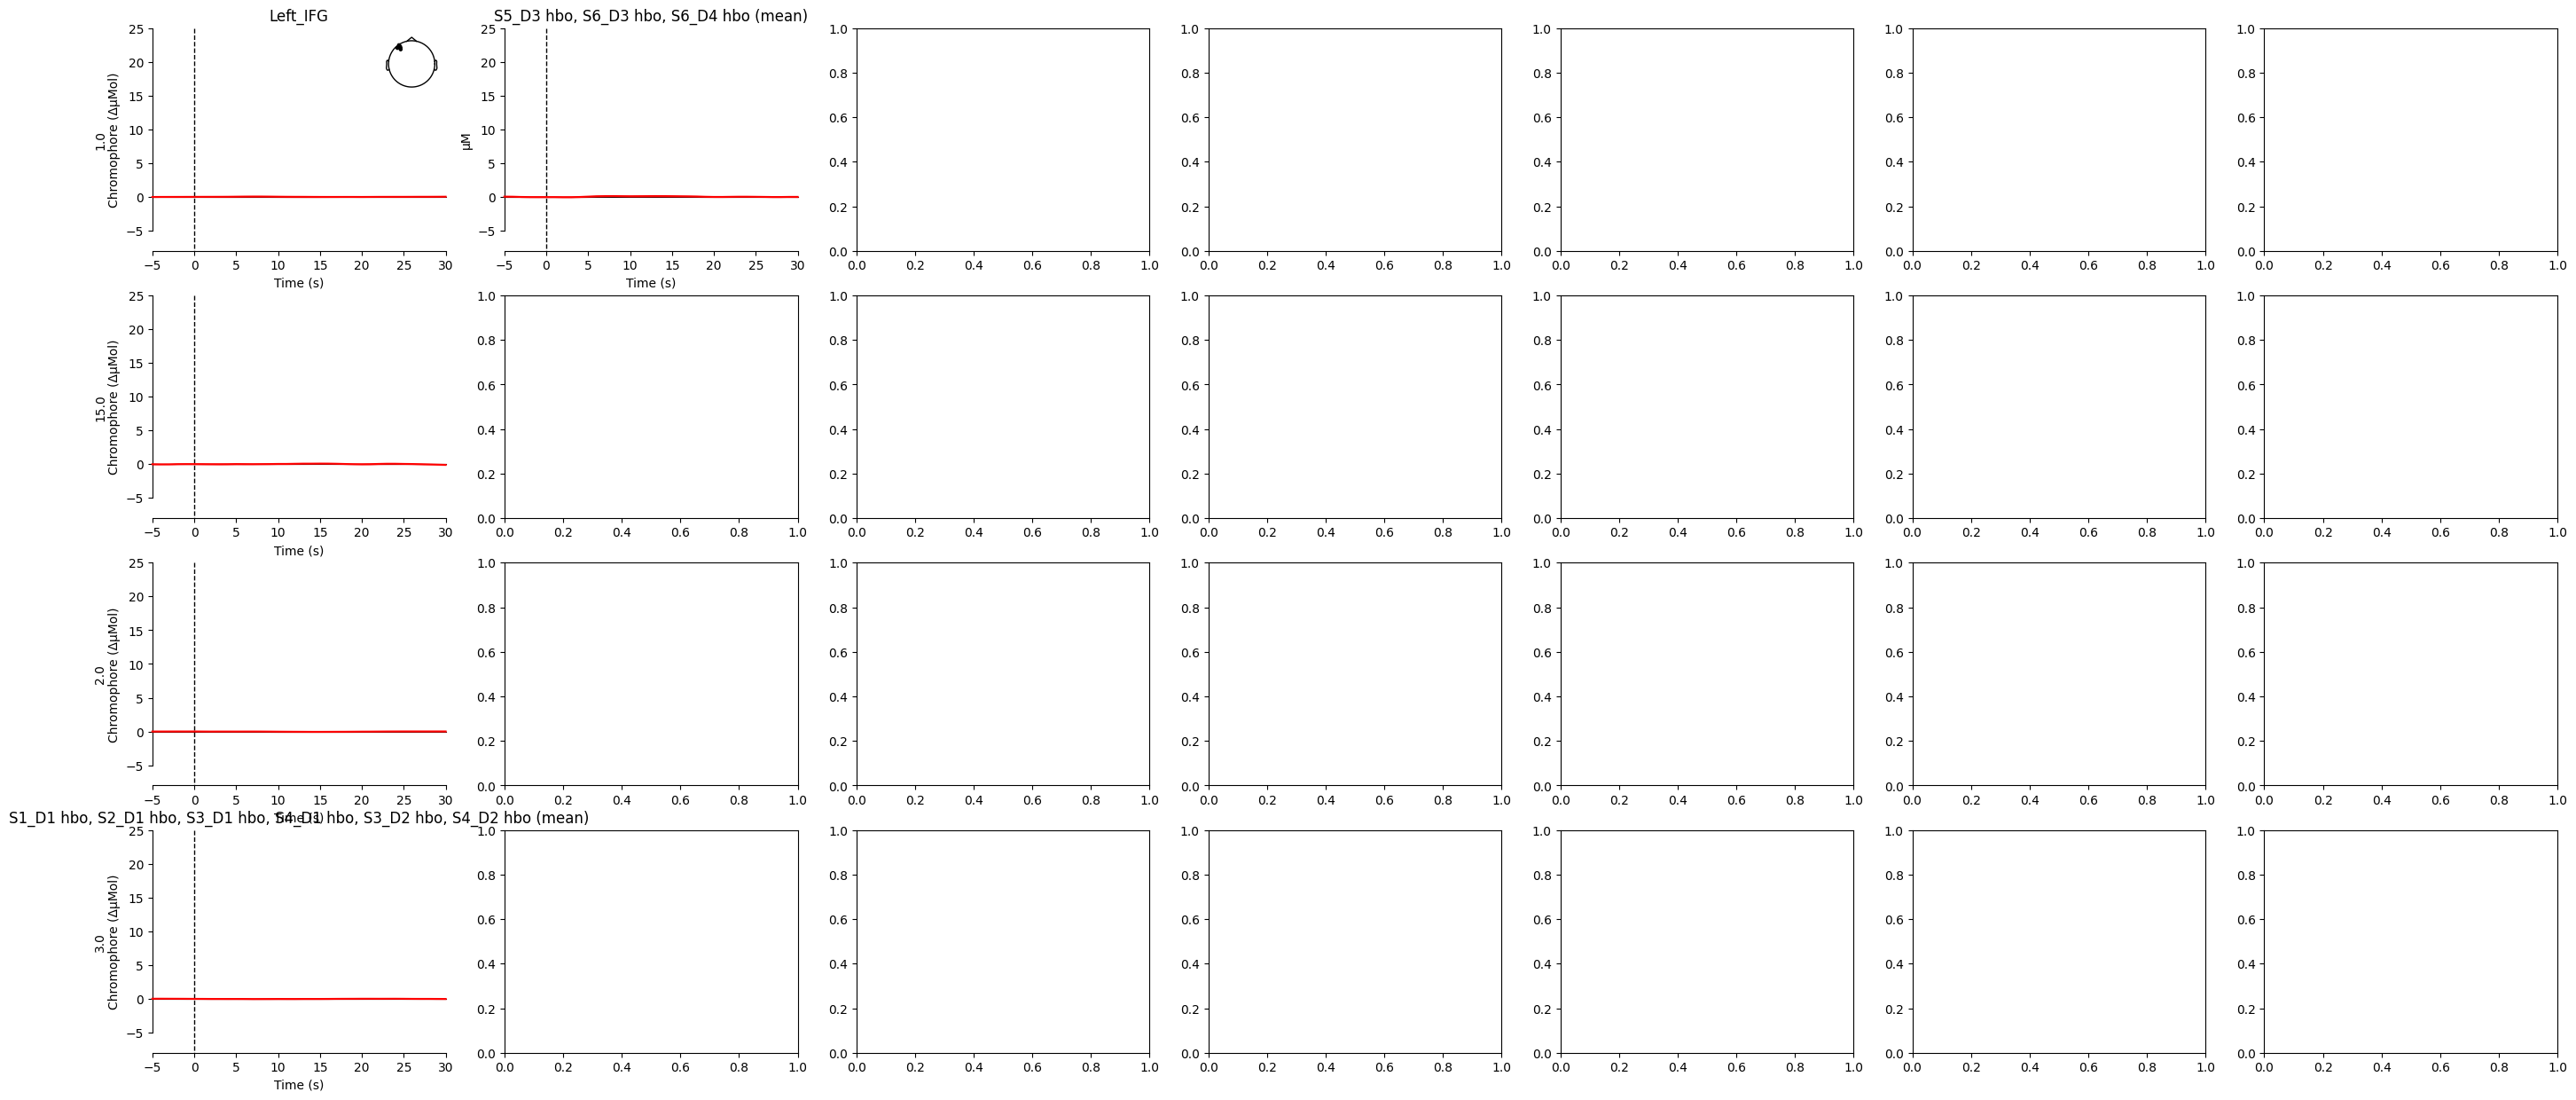

In [4]:
all_evokeds = defaultdict(list)

for sub in range(1, 6):  # Loop from first to fifth subject
    bids_path = BIDSPath(subject="%02d" % sub, task='NHMRCNHAV', suffix="nirs",
                         datatype="nirs", root=r"C:\Users\dalto\Downloads\ml_sourcedata", extension=".snirf")

    raw_haemo, epochs = individual_analysis(bids_path)

    for cidx, condition in enumerate(epochs.event_id):
        all_evokeds[condition].append(epochs[condition].average())

# Then generate the correct indices for each pair and store in dictionary
rois = dict(
    Left_IFG=p2idx(raw_haemo, [[1,1], [2,1], [3,1], [4,1], [3,2], [4,2]], on_missing='warning'),
    Left_HG=p2idx(raw_haemo, [[5,3], [5,4], [5,5], [6,3], [6,4], [6,5]], on_missing='warning'),
    Left_PT=p2idx(raw_haemo, [[6,6], [6,7], [7,5], [7,7], [8,6], [8,7]], on_missing='warning'),
    Right_HG=p2idx(raw_haemo, [[13,10], [13,11], [13,12], [14,10], [14,11], [14,12]], on_missing='warning'),
    Right_PT=p2idx(raw_haemo, [[14,13], [14,14], [15,12], [15,14], [16,13], [16,14]], on_missing='warning'),
    Right_IFG=p2idx(raw_haemo, [[9,8], [10,8], [11,8], [11,9], [12,8], [12,9]], on_missing='warning'),
    OCCI_Lateral=p2idx(raw_haemo, [[15, 13], [15, 14], [16, 15], [16, 14]], on_missing='warning')
)

# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(all_evokeds), ncols=len(rois), figsize=(35, 15))
lims = dict(hbo=[-8, 25], hbr=[-8, 25])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == 'hbr':
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            plot_compare_evokeds(
                {evoked: all_evokeds[evoked]}, combine='mean', picks=picks,
                axes=axes[cidx, ridx], show=False, colors=[color], legend=False,
                ylim=lims, ci=0.95, show_sensors=cidx == 0
            )

            axes[0, ridx].set_title(f"{roi}")
            axes[1, ridx].set_title("")
            axes[2, ridx].set_title("")
            axes[cidx, 0].set_ylabel(f"{evoked}\nChromophore (ΔμMol)")
            
axes[2, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

Channel Type Comparison

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

scores = []
st_scores = []  # spatio-temporal scores
sliding_scores = []  # sliding scores
weird_subs = []
weird_count = 0
hbo_all = []
hbo_epochs = []
gsr_all = []
gsr_epochs = []
fused_epochs = []
event_dict = {}
fused_events = []
appended = False
save = False
union_scores = []

# for ch_type in ["fnirs", "hbo", "hbr"]:
for ch_type in ["hbo"]:
    x_all = []
    y_all = []
    groups = []

    for sub in range(1,2):
        subject_id = "%02d" % sub
        bids_path = BIDSPath(
            subject="%02d" % sub,
            task="wings",
            session='01',
            datatype="nirs",
            suffix='nirs',
            root=r"C:\Users\dalto\Downloads\sourcedata_lm",
            extension=".snirf"
        )

        
        # Read source data
        # fname = str(bids_path.directory)
        # bids_path = r"C:\Users\dalto\Downloads\sub-00\sub-00\2023-07-18_001\2023-07-18_001.snirf"
        fname = r"C:\Users\dalto\Downloads\sub-00\sub-00\2023-07-18_001\2023-07-18_001.snirf"
        print(fname)
        snirf_path = bids_path
        raw = mne.io.read_raw_snirf(fname, preload=False)
        raw.info["line_freq"] = 50  # specify line frequency as required by BIDS
        events, event_id = mne.events_from_annotations(raw)

        raw_haemo, epochs = individual_analysis(fname) #bids_path

        # get haemo channel epochs
        epochs = epochs[["1", "2"]].pick(ch_type)
        
        # set x and y training data
        x = epochs.get_data()
        y = epochs.events[:, 2]

        # print(f"\n\nlen x: {len(x)}\n")
        # print(f"\n\nlen y: {len(y)}\n")

        if ch_type == 'hbo':
            hbo_all.append(x)
            hbo_epochs.append(epochs)
            save = True

            if appended != True:
                fused_events.append(events)
                fused_events.append(events)
                appended = False

            if len(x) < 40:
                weird_subs.append(sub)
                # if sub not in weird_subs[:]:
                weird_count = weird_count + 1

        # appending arrays
        x_all.append(x)
        y_all.append(y)
        groups.append(sub * np.ones(len(x)))       
           
    # do across subjects decoding (leave one subject out)
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    groups = np.concatenate(groups, axis=0)

    # print(f"\nx_all.shape: {x_all.shape}\n")
    # print(f"\ny_all.shape: {y_all.shape}\n")

    print(f"\nChannel type {ch_type} finished rendering!\n")

    logreg = LogisticRegression()
    # logreg = LogisticRegression(solver='liblinear')
    cv = StratifiedKFold()
    # cv = LeaveOneGroupOut()
    
    clf = make_pipeline(
        Scaler(epochs.info), 
        Vectorizer(), LogisticRegression()
    ) 
    # print(f"\n\nepoch.info: {epochs.info}\n")

    # param_grid = {
    #     'penalty' : ['l1', 'l2', 'elasticnet', None],
    #     'dual' : [True,False],
    #     'tol' : [np.exp(-5), np.exp(-4), np.exp(-3)],
    #     'solver' : ['sag','saga','lbfgs','liblinear']
    # }

    # gs = GridSearchCV(
    #     estimator=clf,
    #     param_grid=param_grid,
    #     scoring=['r2', "neg_root_mean_squared_error"],
    #     refit='r2',
    #     cv=LeaveOneGroupOut()
    # )

    # gs.fit(x=x_all,y=y_all,groups=groups)

    # print(f"\nbest params: {gs.best_params_}\n")
    # print(f"\nbest params: {gs.best_score_}\n")

    # tuned_solver = gs.best_estimator_

    st_scores = cross_val_multiscore(
        clf,
        x_all,
        y_all,
        cv=LeaveOneGroupOut(),
        groups=groups,
        n_jobs=1,
        scoring="roc_auc",
    )

    scores.append(
        pd.DataFrame({"Score": st_scores, "method": "Basic", "Channel Type": ch_type})
    )

    if save == True:
        union_scores.append(
            pd.DataFrame({"Score": st_scores, "method": "Basic", "Channel Type": ch_type})
        )
        save = False

    clf = make_pipeline(
        UnsupervisedSpatialFilter(PCA(30), average=True),
        pyriemann.estimation.XdawnCovariances(nfilter=4, estimator='lwf', xdawn_estimator='lwf'),
        pyriemann.classification.MDM(),
    )

    clf = make_pipeline(
        UnsupervisedSpatialFilter(PCA(30), average=True),
        pyriemann.estimation.XdawnCovariances(nfilter=4, estimator='lwf', xdawn_estimator='lwf'),
        pyriemann.classification.MDM(),
    )

    riemann_scores = cross_val_score(
        clf,
        x_all,
        y_all,
        cv=cv,
        groups=groups,
        n_jobs=1,
        scoring="roc_auc",
    )

    scores.append(
        pd.DataFrame({"Score": riemann_scores, "method": "Riemann", "Channel Type": ch_type}))

C:\Users\dalto\Downloads\sub-00\sub-00\2023-07-18_001\2023-07-18_001.snirf
Loading C:\Users\dalto\Downloads\sub-00\sub-00\2023-07-18_001\2023-07-18_001.snirf
Used Annotations descriptions: ['1', '15', '16', '2', '3']
Reading 0 ... 13356  =      0.000 ...  2132.953 secs...

Channel type hbo finished rendering!



ValueError: info had 2 data channels but X has 1152 channels

<Axes: xlabel='Channel Type', ylabel='Score'>

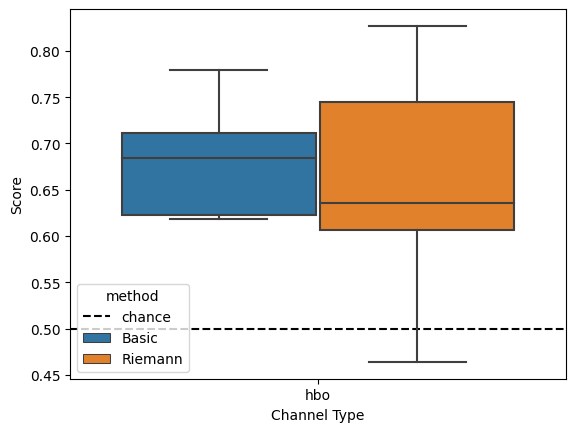

In [ ]:
scores = pd.concat(scores, ignore_index=True)

plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
sns.boxplot(x="Channel Type", y="Score", hue="method", data=scores)

Physio Learning Function

In [ ]:
ch_names = ["Resp.", "PPG", "Sp02", "HR", "GSR", "Temp."]
aux_scores = []
physio_all = []

for ch_type in ch_names:
# for ch_type in ['GSR']:
    aux_x_all = []
    aux_y_all = []
    aux_groups = []
    for sub in range(1,11):
        subject_id = "%02d" % sub
        bids_path = BIDSPath(
            subject="%02d" % sub,
            task="wings",
            session='01',
            datatype="nirs",
            suffix='nirs',
            root=r"C:\Users\dalto\Downloads\sourcedata_lm",
            extension=".snirf"
        )

        raw_haemo = beer_lambert_law(optical_density(read_raw_snirf(bids_path)))
        raw_haemo = raw_haemo.filter(None, 0.4,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)
        raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
        raw_haemo = enhance_negative_correlation(raw_haemo)

        ##### PHYSIO PHOOLERY #####
        # Specify number of physio channels you're using
        n_samples = 6

        # Create a new 2D array to store the results
        result_array = np.empty((len(range(18, 24)), n_samples))  # Replace `n_samples` with the appropriate number

        result_list = []
        # Loop over values of n from 18 to 24
        for i, n in enumerate(range(18, 24)):
            aux_data_match = None  # Initialize aux_data_match variable
            dat = h5py.File(bids_path, 'r')
            aux = np.array(dat.get(f'nirs/aux{n}/dataTimeSeries'))
            aux_time = np.array(dat.get(f'nirs/aux{n}/time'))
            aux_data_interp = interpolate.interp1d(aux_time, aux, axis=0, bounds_error=False, fill_value='extrapolate')
            aux_data_match = aux_data_interp(raw_haemo.times)

            # Append aux_data_match to the result list
            result_list.append(aux_data_match)

        # Convert the list to a 2D array
        result_array = np.array(result_list)
        # print(f"\n\nresult_array: {result_array.mean().shape}\n")

        #### INIT INFO  ####
        sfreq = 1   # sampling data at 1 Hz
        ch_types = ["hbo"] * n_samples
        info = mne.create_info(ch_names,ch_types=ch_types, sfreq=sfreq)

        ####  INIT RAW  ####
        data = aux_data_match
        simulated_raw = mne.io.RawArray(result_array, info).pick(ch_type)
        # simulated_raw.plot(show_scrollbars=False, show_scalebars=False)

        #### INITIALIZE EPOCH ####
        raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
        events, event_dict = events_from_annotations(raw_haemo, verbose=False,
                                                        regexp='^(?![Ends]).*$')
        
        # print(f"\nevents:\n{events}\n")

        aux_epochs = Epochs(simulated_raw, events, event_id=event_dict, tmin=-5, tmax=30,
                        reject_by_annotation=True,
                        proj=True, baseline=(None, 0), detrend=1,
                        preload=True, verbose=False,event_repeated='merge')

        aux_x = aux_epochs.get_data()
        aux_y = aux_epochs.events[:, 2]

        # print(f"\n\naux_x_all: {aux_x}\n")
        # print(f"\n\naux_y_all: {aux_y}\n")

        aux_x_all.append(aux_x)
        aux_y_all.append(aux_y)
        aux_groups.append(sub * np.ones(len(aux_x))) 

        physio_all.append(aux_x)

        if ch_type == 'GSR':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]

            gsr_all.append(aux_x)
            gsr_epochs.append(aux_epochs)


    aux_x_all = np.concatenate(aux_x_all,axis=0)
    aux_y_all = np.concatenate(aux_y_all,axis=0)
    aux_groups = np.concatenate(aux_groups,axis=0)

    

    print(f"\naux_x_all shape:{aux_x_all.shape}\n")
    print(f"\naux_y_all shape:{aux_y_all.shape}\n")

    # for ch_type in ch_names:
    learn(ch_type)

NameError: name 'BIDSPath' is not defined

<Axes: xlabel='Channel Type', ylabel='Score'>

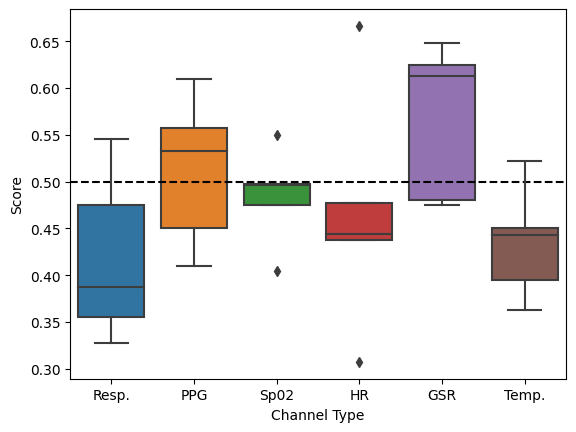

In [ ]:
aux_scores = pd.concat(aux_scores, ignore_index=True)

plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
sns.boxplot(x="Channel Type", y="Score", data=aux_scores)

Create Fused arrays

In [ ]:
hbo_all = np.concatenate(hbo_all,axis=0)
gsr_all = np.concatenate(gsr_all,axis=0)
physio_all = np.concatenate(physio_all,axis=0)

# Create a structured array
fused_all = np.empty((hbo_all.shape[0],), dtype=[('hbo_all', hbo_all.dtype, hbo_all.shape[1:]),
                            ('gsr_all', gsr_all.dtype, gsr_all.shape[1:])])

# Assign the arrays to the structured array
fused_all['hbo_all'] = hbo_all
fused_all['gsr_all'] = gsr_all

Define Feature Fusion Pipeline

In [ ]:
def extract_hbo_all(X):
    return X['hbo_all']

def extract_gsr_all(X):
    return X['gsr_all']


# Create transformers for the sub-array extraction functions
hbo_selector = FunctionTransformer(extract_hbo_all)
gsr_selector = FunctionTransformer(extract_gsr_all)


col_trans = make_column_transformer(
                                    (Scaler(epochs.info), hbo_selector),
                                    (Scaler(aux_epochs.info), gsr_selector),
                                    remainder = 'drop')

hbo_pipe = make_pipeline(hbo_selector,Scaler(epochs.info))
gsr_pipe = make_pipeline(gsr_selector,Scaler(aux_epochs.info))

union = FeatureUnion([
    ('hbo', hbo_pipe),
    ('gsr', gsr_pipe)]
)

pipe = make_pipeline(union, Vectorizer(), logreg)

Fused Model Scoring

<Axes: xlabel='Channel Type', ylabel='Score'>

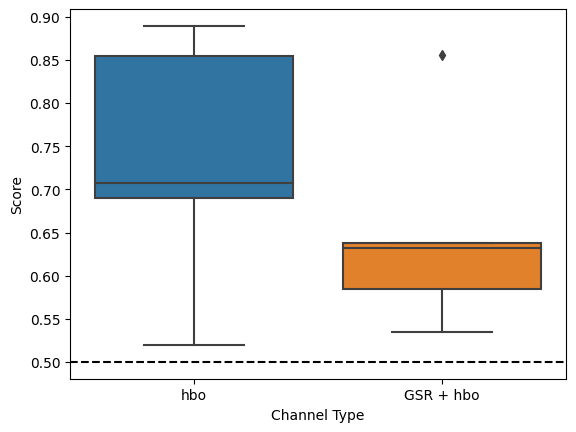

In [ ]:
aux_st_scores = cross_val_multiscore(
    pipe,
    fused_all,
    y_all,
    cv=LeaveOneGroupOut(),
    groups=groups,
    n_jobs=1,
    scoring="roc_auc")

union_scores.append(
    pd.DataFrame({"Score": aux_st_scores, "method":"Basic","Channel Type": "GSR + hbo"}))

union_scores = pd.concat(union_scores, axis=0)

plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
sns.boxplot(x="Channel Type", y="Score", data=union_scores)

Channel types::	fnirs_cw_amplitude: 86


C:\Users\dalto\AppData\Local\Temp\ipykernel_27984\2108271885.py:27: RuntimeWarning: Got coordinate frame "unknown" for ['S1_D1 760', 'S1_D1 760', 'S1_D1 760', 'S1_D2 760', 'S1_D2 760', 'S1_D2 760', 'S1_D3 760', 'S1_D3 760', 'S1_D3 760', 'S1_D4 760', 'S1_D4 760', 'S1_D4 760', 'S1_D5 760', 'S1_D5 760', 'S1_D5 760', 'S1_D15 760', 'S1_D15 760', 'S1_D15 760', 'S2_D3 760', 'S2_D3 760', 'S2_D3 760', 'S2_D5 760', 'S2_D5 760', 'S2_D5 760', 'S2_D16 760', 'S2_D16 760', 'S2_D16 760', 'S3_D4 760', 'S3_D4 760', 'S3_D4 760', 'S3_D5 760', 'S3_D5 760', 'S3_D5 760', 'S3_D6 760', 'S3_D6 760', 'S3_D6 760', 'S4_D2 760', 'S4_D2 760', 'S4_D2 760', 'S4_D4 760', 'S4_D4 760', 'S4_D4 760', 'S4_D6 760', 'S4_D6 760', 'S4_D6 760', 'S4_D17 760', 'S4_D17 760', 'S4_D17 760', 'S5_D6 760', 'S5_D6 760', 'S5_D6 760', 'S5_D7 760', 'S5_D7 760', 'S5_D7 760', 'S5_D18 760', 'S5_D18 760', 'S5_D18 760', 'S6_D6 760', 'S6_D6 760', 'S6_D6 760', 'S6_D7 760', 'S6_D7 760', 'S6_D7 760', 'S6_D8 760', 'S6_D8 760', 'S6_D8 760', 'S7_D8 760